#  Monte calro localization  
Monte calro localizationのサンプルです。  

## ライブラリのインポート

In [1]:
%matplotlib inline
import math, random                 # 計算用、乱数の生成用ライブラリ
import matplotlib.pyplot as plt # 描画用ライブラリ

## ランドマーククラス  
下のグラフに表示されている星たちです。  
ロボットはこの星を目印にして自分の位置を知ります。  
今回は星の位置もロボットが覚えている設定です。  
ロボットがどんな風に星を見ているのかは、観測モデルのクラスを見てください。  

In [2]:
class Landmarks:
    def __init__(self, array):
        self.positions = array # array = [[星1のx座標, 星1のy座標], [星2のx座標, 星2のy座標]...]
    
    def draw(self):
        # ランドマークの位置を取り出して描画
        xs = [e[0] for e in self.positions]
        ys = [e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

## 移動モデルクラス  
fwだけ前に進んで、rotだけ回転します。  
ロボットは正確に走らないし、滑ったりもするので、random.gaussによって擬似的に表現します。  
実際のロボットでは、試しに動かしてみることで、動きの正確さや傾向を調べておきます。  

In [3]:
def Movement(pos, fw, rot):
    # 移動モデル
    # posからfw前進、rot回転した位置をリストで返す
    
    # 雑音の入った前進、回転の動き
    actual_fw = random.gauss(fw, fw/10) # 10%の標準偏差でばらつく
    actual_rot = random.gauss(rot, rot/10) # 10%の標準偏差でばらつく
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 3[deg]の標準偏差
    
    # 異動前の位置を保存
    px, py, pt = pos

    # 移動後の位置を計算
    x = px + actual_fw * math.cos(pt + dir_error)
    y = py + actual_fw * math.sin(pt + dir_error)
    t = pt + dir_error + actual_rot # dir_errorを足す

    # 結果を返す
    return [x,y,t]

## 観測モデルクラス  
ランドマーククラスで指定した☆を一個ずつ見ます。  
ロボットには自分から見た☆の距離と方向がわかります。  
こちらも移動モデル同様に正確には読み取れないので、random.gaussで再現します。  
今回のロボットの視野角は180度、距離は1まで見れます。  

In [4]:
def Observation(pos, landmark):
    # 観測モデル
    # posから見えるランドマークの距離と方向をリストで返す
    
    obss = []
    
    # センサの計測範囲
    # 距離0.1 ~ 1
    # 角度90 ~ -90[deg]
    sensor_max_range = 1.0
    sensor_min_range = 0.1
    sensor_max_angle = math.pi / 2
    sensor_min_angle = -math.pi / 2
    
    # ロボットやパーティクルの位置姿勢を保存
    rx, ry, rt = pos
    
    # ランドマークごとに観測
    for lpos in landmark.positions:
        true_lx, true_ly = lpos
        # 観測が成功したらresultをTrue
        result = True

        # ロボットとランドマークの距離を計算
        # センサの範囲外であればresultがFalseに
        distance = math.sqrt((rx - true_lx) ** 2 + (ry - true_ly) ** 2)
        if distance > sensor_max_range or distance < sensor_min_range:
            result = False

        # ロボットから見えるランドマークの方向を計算
        # こちらもセンサの範囲外であればresultがFalseに
        direction = math.atan2(true_ly - ry, true_lx - rx) - rt
        if direction > math.pi: direction -= 2 * math.pi
        if direction < - math.pi: direction += 2 * math.pi
        if direction > sensor_max_angle or direction < sensor_min_angle:
            result = False

        # 雑音の大きさを設定
        # これは尤度計算に使う正規分布関数の分散になる
        sigma_d = distance * 0.1 # 10%の標準偏差
        sigma_f = math.pi * 3 / 180 # 3degの標準偏差

        # 雑音を混ぜる
        d = random.gauss(distance, sigma_d)
        f = random.gauss(direction, sigma_f)
        
        # 観測データを保存
        z = []
        z.append([d, f, sigma_d, sigma_f, result])
        
    return z

## パーティクルクラス  
下のグラフに描画されますが、青くていっぱいある矢印たちのことです。  
ロボットと同様に星を目印にしながら動きますが、重みwを持っていますwww  
ロボットと観測結果が似ていると重みの値は大きくなり、大きいほど生き残る確率が高いです。  
なので観測がうまくいっていれば、自然とロボットの位置に近いパーティクルたちだけになっていきます。  

In [5]:
class Particle:
    def __init__(self, x, y, t, w):
        # パーティクルは位置姿勢と重みを持つ
        self.pos = [x, y, t]
        self.w = w
        
class Particles:
    # numはパーティクルの個数
    def __init__(self, x, y, t, num):
        self.particles = []
        for i in range(num):
            # とりあえず重みはみんな一緒
            self.particles.append(Particle(x, y, t, 1.0 / num))
    
    def move(self, fw, rot):
        # パーティクルを移動
        for i in self.particles:
            i.pos  = Movement(i.pos, fw, rot)
            
    def observation(self, landmarks):
        # パーティクルからの観測データzを保存
        for i in self.particles:
            i.z = Observation(i.pos, landmarks)
    
    def likelihood(self, robot):
        for particle in self.particles:
            for i in range(len(particle.z)):
                
                # 各パーティクルの観測データをロボットのものと比較
                rd, rf, sigma_rd, sigma_rf, result_r = robot.z[i]
                pd, pf, sigma_pd, sigma_pf, result_p = particle.z[i]
                
                # ロボットとパーティクル共にresultがTrueになっていれば計算
                if result_r and result_p:
                    # 尤度計算は正規分布の掛け合わせ
                    # ロボットと観測データが近いパーティクルは尤度が高くなる
                    likelihood_d = math.exp(-(rd - pd) ** 2 / (2 * (sigma_rd ** 2))) / (sigma_rd * math.sqrt(2 * math.pi))
                    likelihood_f = math.exp(-(rf - pf) ** 2 / (2 * (sigma_rf ** 2))) / (sigma_rf * math.sqrt(2 * math.pi))
                    # 尤度をパーティクルの重みとして保存
                    particle.w *= likelihood_d * likelihood_f
                    
    def resampling(self):
        num = len(self.particles)
        # 重みリストの作成
        ws = [e.w for e in self.particles]
        # 重みの大きいパーティクルほど高い確率で選ばれる
        ps = random.choices(self.particles, weights = ws, k = num)
        # 選ばれたパーティクルの位置、方向を引き継いで、再び均等な重みのパーティクルを作成
        self.particles = [Particle(*e.pos, 1.0 / num) for e in ps]
        
    # 矢印の描画に必要な位置と方向を計算して描画
    def draw(self, c = "blue", lbl = "particles"):
        xs = [p.pos[0] for p in self.particles]
        ys = [p.pos[1] for p in self.particles]
        vxs = [math.cos(p.pos[2]) for p in self.particles]
        vys = [math.sin(p.pos[2]) for p in self.particles]
        plt.quiver(xs, ys, vxs, vys, color = c, label = lbl, alpha = 0.7)

## ロボットクラス  
基本的な構造はパーティクルと変わりません。  
わかりやすさのために位置を配列に保存して、軌跡を表示しています。  
下のグラフを見るとわかると思います。  

In [6]:
class Robot:
    def __init__(self, x, y, rad):
        # ステップごとにロボットの姿勢の真値が入った配列
        self.actual_poses = [[x,y,rad]]

    def move(self,fw,rot):
        # ロボットの位置を記録する(軌跡を残すために配列に入れてる)
        self.actual_poses.append(Movement(self.actual_poses[-1], fw, rot))
        
    def observation(self, landmarks):
        # 現在地から見た観測データの保存
        self.z = Observation(self.actual_poses[-1], landmarks)

    # 矢印の描画に必要な位置と方向を計算して描画
    def draw(self, sp):
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")

## 描画クラス  
グラフの大きさなどを設定し、順に描画メソッドを実行させています。  

In [7]:
def draw(i):
    # グラフの設定
    fig = plt.figure(i, figsize=(8,8))
    sp = fig.add_subplot(111,aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    # パーティクル、ロボット、ランドマークの描画
    particles.draw()
    robot.draw(sp)
    actual_landmarks.draw()
    
    plt.legend()

## シミュレーション開始  
ロボット、パーティクル、ランドマークの位置を指定し、シミュレーションを始めます。  

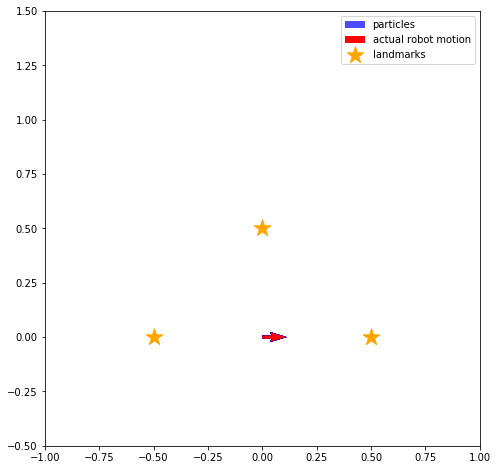

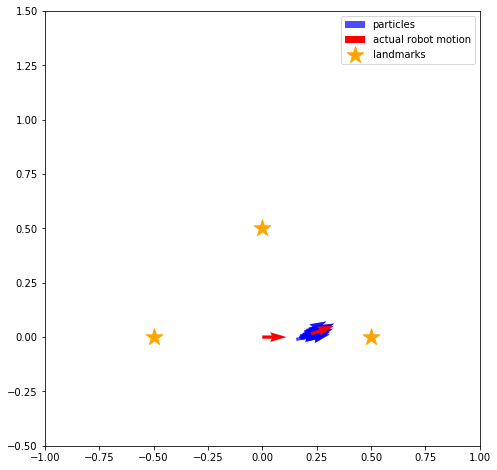

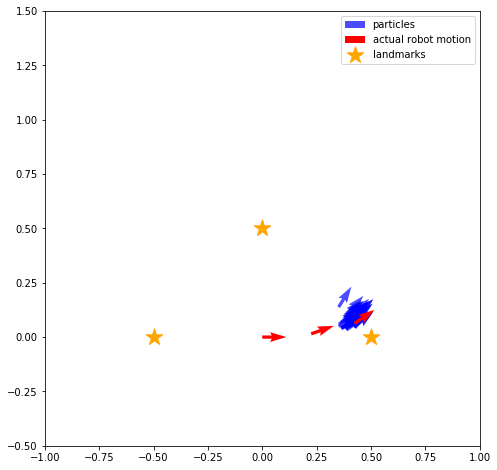

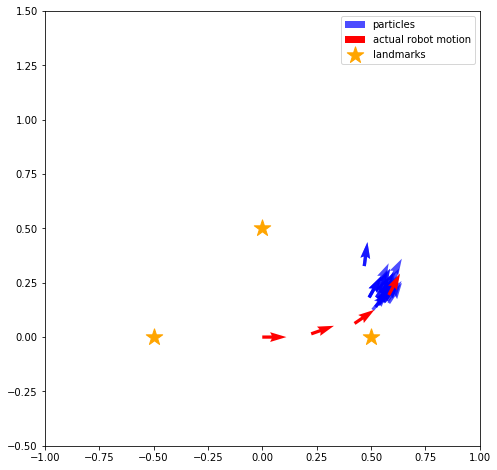

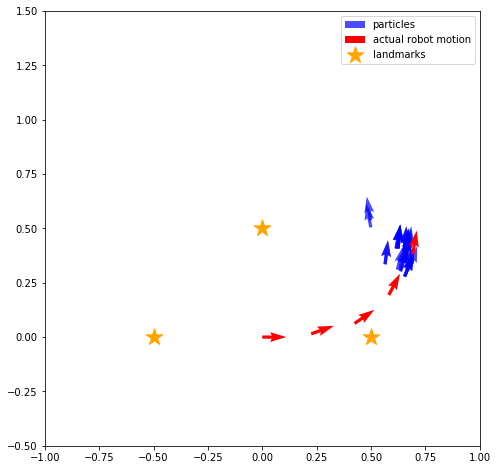

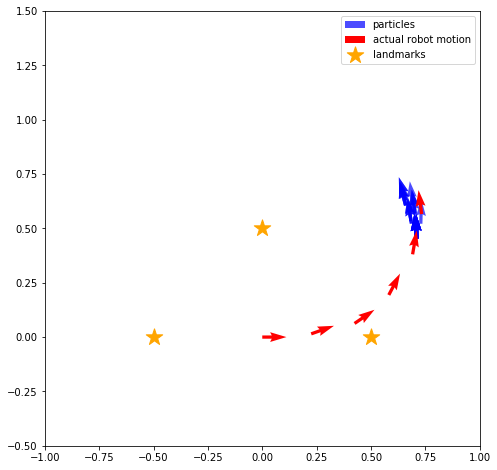

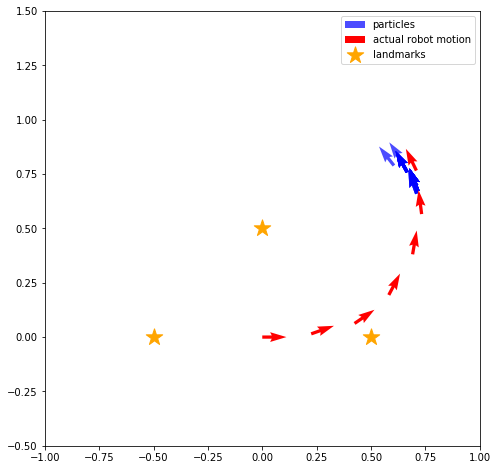

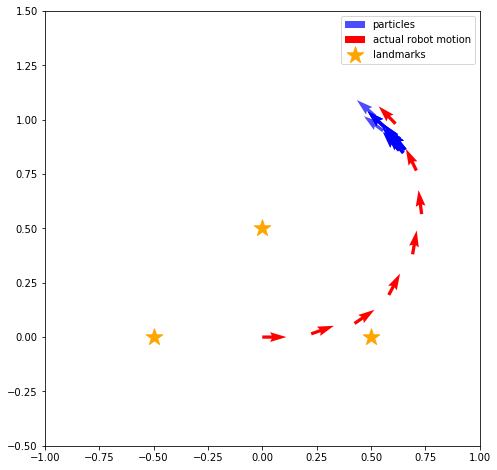

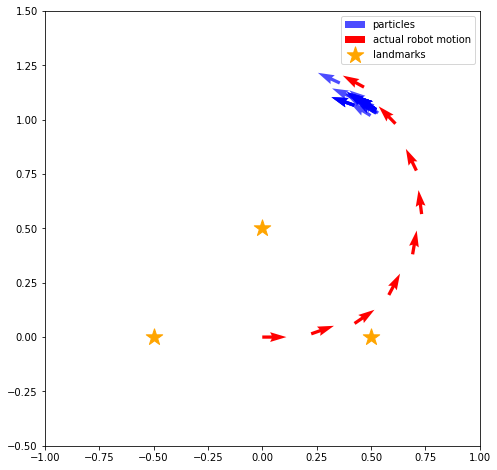

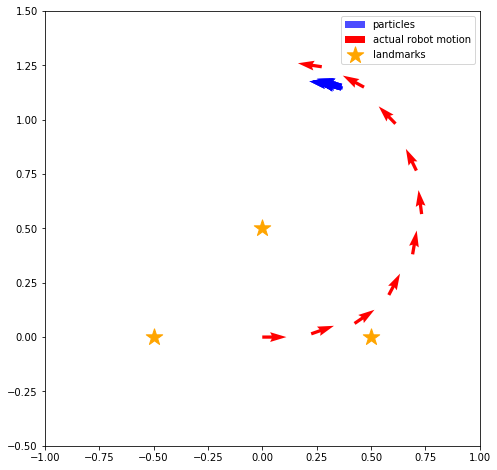

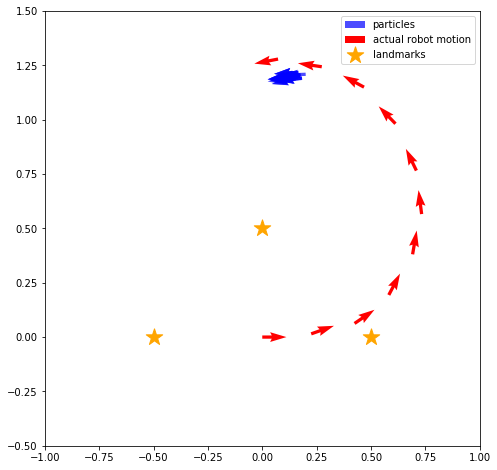

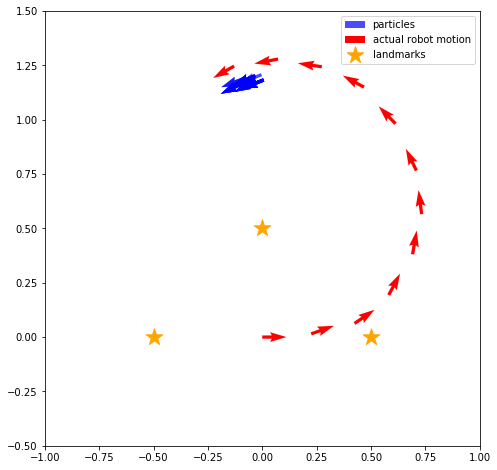

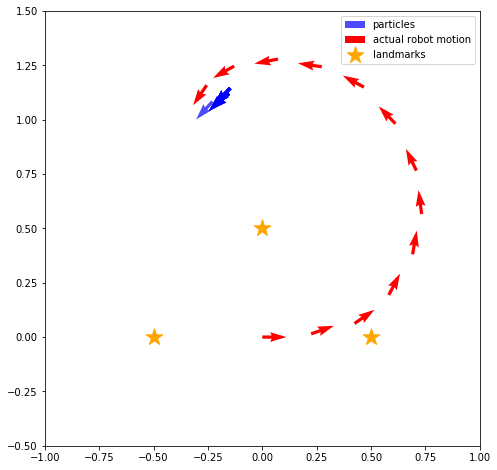

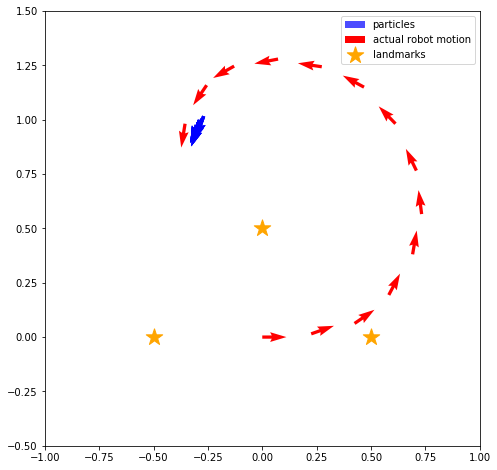

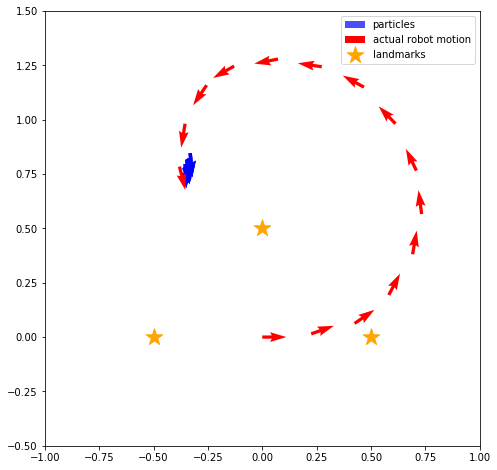

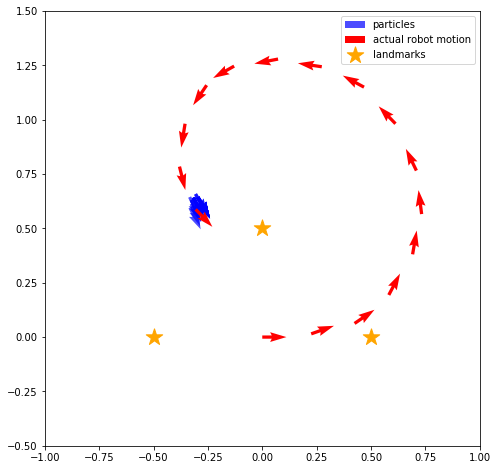

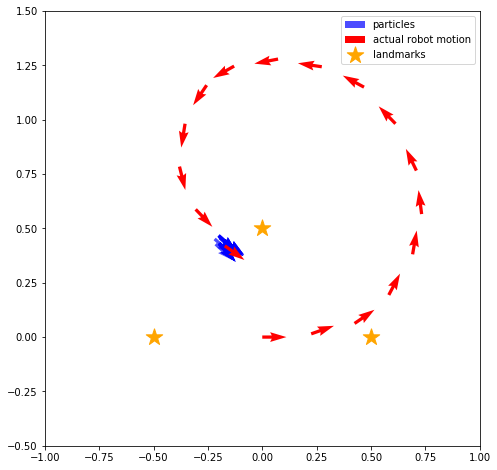

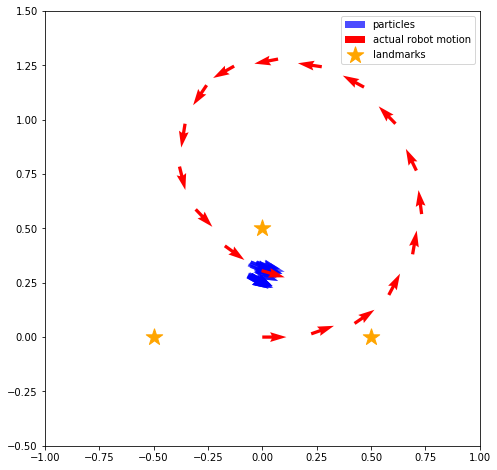

In [8]:
# ロボット、パーティクル、ランドマークの配置と初期化
robot = Robot(0, 0, 0)
particles = Particles(0, 0, 0, 30)
actual_landmarks = Landmarks([[-0.5,0.0],[0.5,0.0],[0.0,0.5]])
draw(0)

for i in range(1,18):
    # ロボットとパーティクルの移動
    robot.move(0.2,math.pi / 180.0 * 20)
    particles.move(0.2,math.pi / 180.0 * 20)
    
    # ロボットとパーティクルの観測
    robot.observation(actual_landmarks)
    particles.observation(actual_landmarks)
    
    # 尤度計算
    particles.likelihood(robot)
    
    # リサンプリング
    particles.resampling()
    
    # 描画
    draw(i)